# Lab Session Reinforcement Learning

## TP1 Qlearning and Sarsa for taxi (openAI gym) - Yann Terrom

**Configuration for rendering in colab**

In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

    !touch .setup_complete

#This code generates a virtual display for rendering game images. It remains inactive if your machine is equipped with a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

### Import and configuration

In [2]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt

from collections import defaultdict
%matplotlib inline

In [3]:
!pip3 install -q gymnasium[classic-control]

## QLearning

In [4]:
class QLearningAgent:
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        """
Q-Learning Agent based on https://inst.eecs.berkeley.edu/~cs188/sp19/projects.html. You have access to the following instance variables:

- `self.epsilon` (exploration probability)
- `self.alpha` (learning rate)
- `self.discount` (discount rate, also known as gamma)

Functions you should utilize:

- `self.get_legal_actions(state)` {state, hashable -> list of actions, each is hashable} which returns legal actions for a state.
- `self.get_qvalue(state, action)` which returns Q(state, action).
- `self.set_qvalue(state, action, value)` which sets Q(state, action) := value.

**Important Note:** Please refrain from using `self._qValues` directly; instead, use the dedicated `self.get_qvalue` and `self.set_qvalue` methods.
        """

        self.get_legal_actions = get_legal_actions
        self._qvalues = defaultdict(lambda: defaultdict(lambda: 0))
        self.alpha = alpha
        self.epsilon = epsilon
        self.discount = discount

    def get_qvalue(self, state, action):
        """ Returns Q(state,action) """
        return self._qvalues[state][action]

    def set_qvalue(self, state, action, value):
        """ Sets the Qvalue for [state,action] to the given value """
        self._qvalues[state][action] = value

    #---------------------START OF YOUR CODE---------------------#

    def get_value(self, state):
        """
       Calculate your agent's estimation of V(s) using the current q-values:

        \[ V(s) = \max_{\text{over\_action}} Q(\text{state, action}) \]

        Note: Consider that q-values may be negative.
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        value = max(self.get_qvalue(state, action) for action in possible_actions)

        return value

    def update(self, state, action, reward, next_state):
        """
        You should do your Q-Value update here:
           Q(s,a) := (1 - alpha) * Q(s,a) + alpha * (r + gamma * V(s'))
        """

        # agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        current_qvalue = self.get_qvalue(state, action)
        next_value = self.get_value(next_state)
        updated_qvalue = (1 - learning_rate) * current_qvalue + learning_rate * (reward + gamma * next_value)

        self.set_qvalue(state, action, updated_qvalue)

    def get_best_action(self, state):
        """
        Compute the best action to take in a state (using current q-values).
        """
        possible_actions = self.get_legal_actions(state)

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        best_action =  max(possible_actions, key=lambda action: self.get_qvalue(state, action))
        return best_action

    def get_action(self, state):
        """
        Determine the action to take in the current state, incorporating exploration.
        With a probability of self.epsilon, choose a random action; otherwise, select the best policy action using self.get_best_action.

        Note: For randomly selecting from a list, use random.choice(list).
        To generate a True or False value based on a given probability,
        generate a uniform number in the range [0, 1] and compare it with the specified probability.
        """

        # Pick Action
        possible_actions = self.get_legal_actions(state)
        action = None

        # If there are no legal actions, return None
        if len(possible_actions) == 0:
            return None

        # agent parameters:
        epsilon = self.epsilon

        if random.random() < epsilon:
          chosen_action = random.choice(possible_actions)
        else :
          chosen_action = self.get_best_action(state)

        return chosen_action


Here we use the Q-Learning agent on the Taxi-v3 environment from OpenAI gym.

In [5]:
import gymnasium as gym
env = gym.make("Taxi-v3", render_mode='rgb_array')

n_actions = env.action_space.n

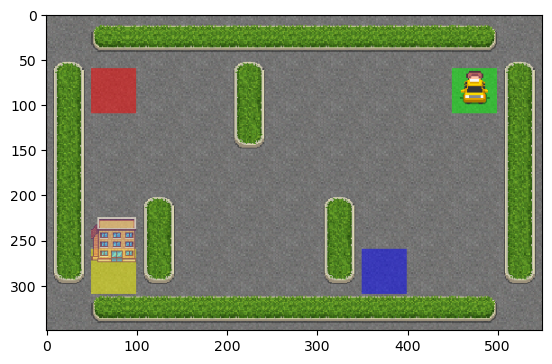

In [6]:
s, _ = env.reset()
plt.imshow(env.render())

In [7]:
agent = QLearningAgent(
    alpha=0.5, epsilon=0.25, discount=0.99,
    get_legal_actions=lambda s: range(n_actions))

In [8]:
def play_and_train(env, agent, t_max=10**4):
    """
This function is designed to:

    Execute a complete game, with actions determined by the agent's epsilon-greedy policy.
    Train the agent using agent.update(...) whenever applicable.
    Return the total reward obtained during the game.
    """
    total_reward = 0.0
    s, _ = env.reset()

    for t in range(t_max):
        # get agent to pick action given state s.
        a = agent.get_action(s)

        # Perform the selected action and observe the next state, reward, and whether the game is done.
        next_s, r, done, _, _ = env.step(a)

        # train (update) agent for state s
        agent.update(s, a, r, next_s)

        # Update the current state.
        s = next_s

        # Accumulate the total reward.
        total_reward += r

        # Check if the game is done.
        if done:
            break

    return total_reward

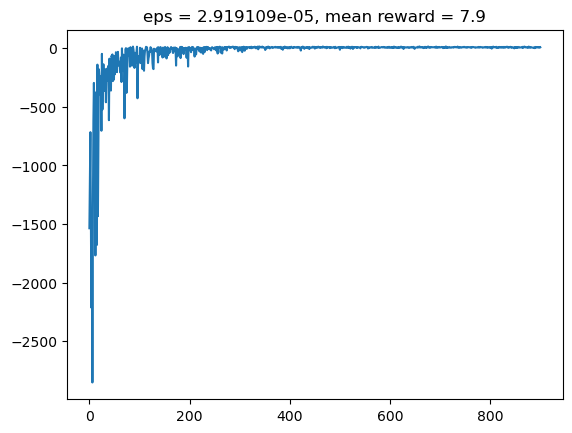

In [9]:
from IPython.display import clear_output

rewards = []
for i in range(1000):
    rewards.append(play_and_train(env, agent))
    agent.epsilon *= 0.99

    if i % 100 == 0:
        clear_output(True)
        plt.title('eps = {:e}, mean reward = {:.1f}'.format(agent.epsilon, np.mean(rewards[-10:])))
        plt.plot(rewards)
        plt.show()

In [10]:
def show_state(env, step=0, info=""):
    clear_output(True)
    plt.imshow(env.render())
    plt.axis('off')
    plt.pause(0.3)

def display_epoch_state(env, agent):
    """Display the state of the environment for a specific epoch."""
    plt.figure(3)
    state = env.reset()[0]
    done = False
    show_state(env)
    while not done:
        action = agent.get_action(state)
        next_state, reward, done, _, _ = env.step(action)
        state = next_state
        show_state(env)


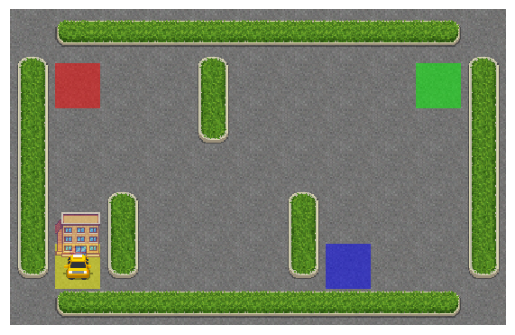

In [11]:
display_epoch_state(env, agent)

## Sarsa

Now we will use a policy. The policy to be employed is the epsilon-greedy policy, wherein the agent selects the optimal action with a probability of (1−ϵ). Otherwise, it randomly samples an action. It's important to note that, by pure chance, the agent may occasionally sample the optimal action even during random selection.

In [12]:
class SarsaAgent(QLearningAgent):
    def __init__(self, alpha, epsilon, discount, get_legal_actions):
        super(SarsaAgent, self).__init__(alpha, epsilon, discount, get_legal_actions)

    def update(self, state, action, reward, next_state, next_action):
        """
        SARSA update:
        Q(s, a) := Q(s, a) + alpha * (r + gamma * Q(s', a') - Q(s, a))
        """

        # Agent parameters
        gamma = self.discount
        learning_rate = self.alpha

        # Q-value update
        current_qvalue = self.get_qvalue(state, action)
        next_qvalue = self.get_qvalue(next_state, next_action)
        updated_qvalue = current_qvalue + learning_rate * (reward + gamma * next_qvalue - current_qvalue)

        self.set_qvalue(state, action, updated_qvalue)


In [13]:
sarsa_agent = SarsaAgent(
    alpha=0.5, epsilon=0.25, discount=0.99,
    get_legal_actions=lambda s: range(n_actions))

In [14]:
def play_and_train_sarsa(env, agent, t_max=10**4):
    total_reward = 0.0
    state, _ = env.reset()

    for t in range(t_max):
        # Choisissez une action avec l'agent
        action = agent.get_action(state)

        # Effectuez l'action dans l'environnement
        next_state, reward, done, _, _ = env.step(action)

        # Choisissez la prochaine action avec l'agent (pour SARSA)
        next_action = agent.get_action(next_state)

        # Mettez à jour l'agent en utilisant SARSA
        agent.update(state, action, reward, next_state, next_action)

        state = next_state
        total_reward += reward

        if done:
            break

    return total_reward


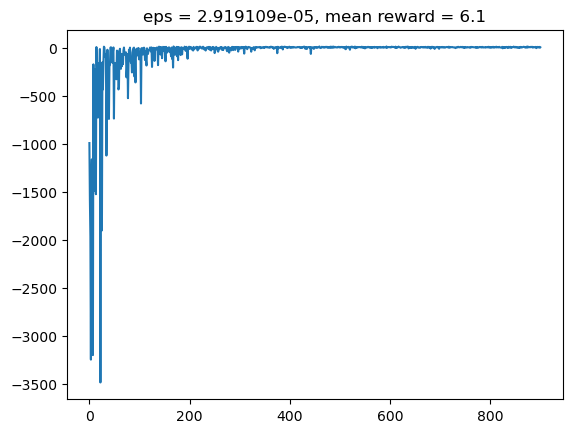

In [15]:
rewards = []
for i in range(1000):
    rewards.append(play_and_train_sarsa(env, sarsa_agent))
    sarsa_agent.epsilon *= 0.99

    if i % 100 == 0:
        clear_output(True)
        plt.title('eps = {:e}, mean reward = {:.1f}'.format(sarsa_agent.epsilon, np.mean(rewards[-10:])))
        plt.plot(rewards)
        plt.show()

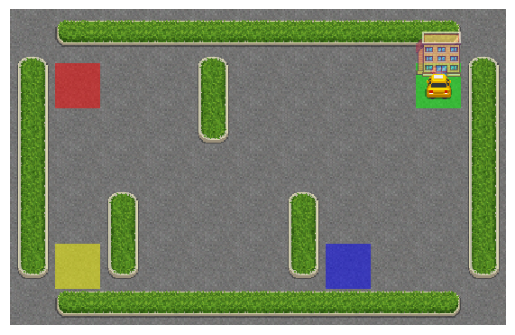

In [16]:
display_epoch_state(env, sarsa_agent)